We want to check whether DeGAS can be used to maximize the probability of being in a set of states during the evolution of a system

In [1]:
import torch
from torch import distributions

### A simple univariate dynamical system

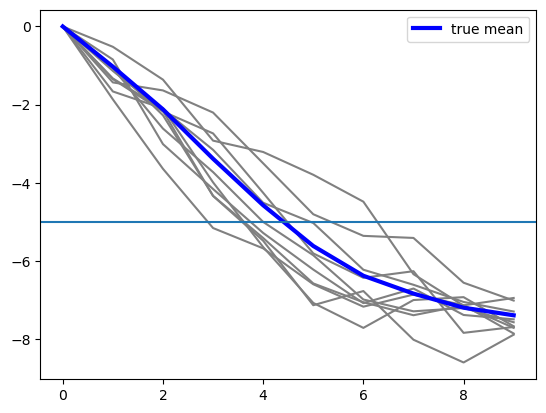

In [2]:
from cps.original_models import *

T = 10

def original_model(T, x0, r, K, h):

    x = torch.zeros(T)
    x[0] = x0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*r*x[i-1] + dt*K*x[i-1]**2 - dt*h + distributions.Normal(0, 0.5).sample()
        
    return x 

orig_traj = generate_traj(original_model, 100, {'T': T, 'x0': 0, 'r': 2.5, 'K': 0.5, 'h': 10})

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.axhline(y = -5)

In [3]:
from optimization import *

soga_program = """
array[11] x;
newx = 0.;

for i in range(11){

    x[i] = newx;
    
    term1 = _r*x[i];

    term2 = _K*x[i];
    term2 = term2*x[i];

    newx = x[i] + 0.1*term1 + 0.1*term2 - 0.1*_h + gauss(0., 0.5);
} end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'r': 2.5, 'K': 0.5, 'h': 10.})

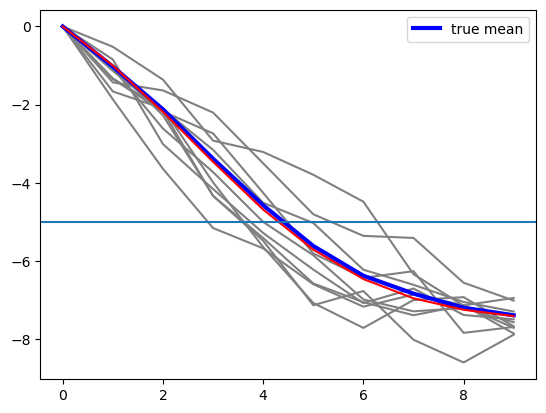

In [4]:
from cps.original_models import *


plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.plot(range(T), output_dist.gm.mean().detach().numpy()[:T], color='red', label='soga mean')
plt.axhline(y = -5)

In [5]:
# The loss maximize the probability of being > -5 at the final time step
loss = lambda dist : -(1 - dist.gm.marg_cdf(torch.tensor([-5.]), idx=10))

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'r': 2.5, 'K': 0.5, 'h': 10.}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=0.01)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")



r: 2.4900007247924805 K: 0.5099998712539673 h: 9.990004539489746  loss: -9.894371032714844e-06
r: 2.480445623397827 K: 0.5195602178573608 h: 9.980451583862305  loss: -2.3066997528076172e-05
r: 2.4712908267974854 K: 0.528724730014801 h: 9.971299171447754  loss: -4.9114227294921875e-05
r: 2.4624156951904297 K: 0.5376126766204834 h: 9.962427139282227  loss: -9.679794311523438e-05
r: 2.4537103176116943 K: 0.5463334321975708 h: 9.953725814819336  loss: -0.00017976760864257812
r: 2.4450907707214355 K: 0.5549705028533936 h: 9.945112228393555  loss: -0.00031816959381103516
r: 2.436494827270508 K: 0.5635857582092285 h: 9.9365234375  loss: -0.00054168701171875
r: 2.4278757572174072 K: 0.5722258687019348 h: 9.927913665771484  loss: -0.00089263916015625
r: 2.4191975593566895 K: 0.5809271335601807 h: 9.919245719909668  loss: -0.0014301538467407227
r: 2.410430669784546 K: 0.5897186994552612 h: 9.910490989685059  loss: -0.002234339714050293
r: 2.4015512466430664 K: 0.5986247658729553 h: 9.90162563323

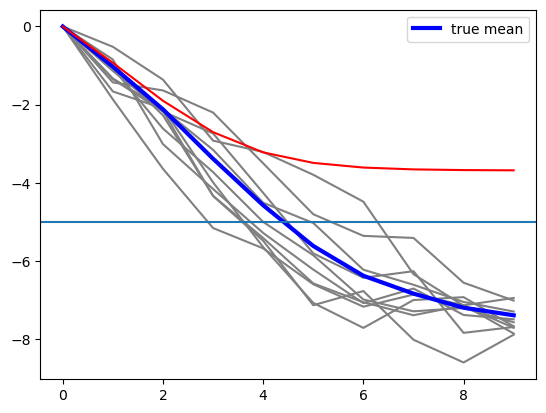

In [6]:

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict)


plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.plot(range(T), output_dist.gm.mean().detach().numpy()[:T], color='red', label='soga mean')
plt.axhline(y=-5)

# Two dimensional example

## Damped Oscillator

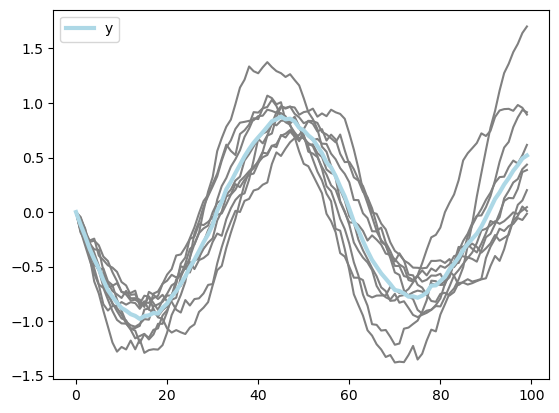

In [7]:
from cps.original_models import *

def original_model(T, x0, y0, a, b, c):

    x = torch.zeros(T)
    y = torch.zeros(T)
    x[0] = x0
    y[0] = y0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*y[i-1] + distributions.Normal(0, 0.05).sample()
        y[i] = y[i-1] - dt*a*x[i-1] - dt*b*y[i-1] - dt*c*x[i-1]**3 + distributions.Normal(0, 0.05).sample()
    
    return x, y

x_list = []
y_list = []

init_params = {'T': 100, 'x0': 1., 'y0': 0., 'a': 1.0, 'b': 0.2, 'c': 0.1}


for _ in range(10):

    x, y = original_model(**init_params)
    x_list.append(x)
    y_list.append(y)

x_list = torch.stack(x_list)
y_list = torch.stack(y_list)

plot_traj_set(y_list, single_traj=10, color='lightblue', label='y')
plt.legend()

In [8]:
from optimization import *

soga_program = """
array[101] x;
array[101] y;

newx = 1.;
newy = 0.;

for i in range(101){

    x[i] = newx;
    y[i] = newy;
    
    term1y = _a*x[i];
    
    term2y = _b*y[i];

    term3y = _c*y[i];
    term3y = term3y*y[i];
    term3y = term3y*y[i];

    newx = x[i] + 0.1*y[i] + gauss(0., 0.05);
    newy = y[i] - 0.1*term1y - 0.1*term2y - 0.1*term3y + gauss(0., 0.05);

    } end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'a': 1.0, 'b': 0.2, 'c': 0.1})

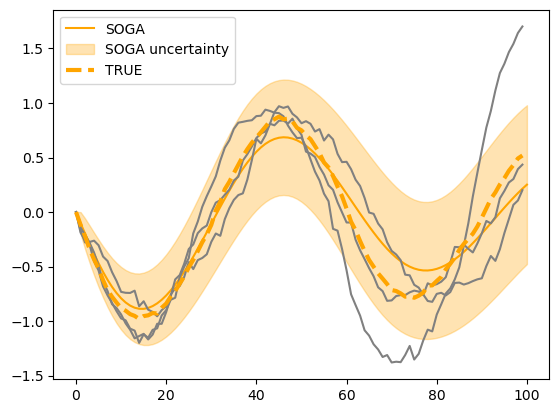

In [9]:
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

mean_y = output_dist.gm.mean().detach().numpy()[y_idx]
plt.plot(range(len(y_idx)), mean_y, color='orange', label='SOGA')
std_y = 2*torch.sqrt(torch.diag(output_dist.gm.cov()[y_idx, :][:, y_idx])).detach().numpy()
plt.fill_between(range(len(y_idx)), mean_y - std_y, mean_y + std_y, color='orange', alpha=0.3, label='SOGA uncertainty')

plot_traj_set(y_list, single_traj=3, ls='--', color='orange', label='TRUE')
plt.legend()

In [10]:
loss = lambda dist : dist.gm.marg_cdf(torch.tensor([0.25]), idx=201) - dist.gm.marg_cdf(torch.tensor([-0.25]), idx=201)

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 1.0, 'b': 0.2, 'c': 0.1}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

curr_loss = loss(output_dist)

print(curr_loss.item())

curr_loss.backward()

for key, value in params_dict.items():
    print(f"{key}: grad={value.grad}")

0.4142861068248749
a: grad=-1.3995038270950317
b: grad=1.0702850818634033
c: grad=0.5581764578819275


In [11]:
# The loss maximizes the probability of being between -0.25 and 0.25 at the final time step

loss = lambda dist : -(dist.gm.marg_cdf(torch.tensor([0.25]), idx=201) - dist.gm.marg_cdf(torch.tensor([-0.25]), idx=201))

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 1.0, 'b': 0.2, 'c': 0.1}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=1e-2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

a: 0.9900000095367432 b: 0.21000000834465027 c: 0.10999999940395355  loss: -0.4142861068248749
a: 0.980035662651062 b: 0.21997928619384766 c: 0.1199212446808815  loss: -0.44318798184394836
a: 0.9701416492462158 b: 0.2299228310585022 c: 0.12970344722270966  loss: -0.46922701597213745
a: 0.9603593945503235 b: 0.23981638252735138 c: 0.13928678631782532  loss: -0.4924243986606598
a: 0.9507358074188232 b: 0.24964740872383118 c: 0.14861688017845154  loss: -0.5129042863845825
a: 0.9413213729858398 b: 0.25940582156181335 c: 0.15764866769313812  loss: -0.5308654308319092
a: 0.9321678876876831 b: 0.2690843343734741 c: 0.1663488894701004  loss: -0.5465532541275024
a: 0.9233260154724121 b: 0.2786785960197449 c: 0.1746968775987625  loss: -0.5602388381958008
a: 0.914842963218689 b: 0.28818705677986145 c: 0.18268389999866486  loss: -0.5722000002861023
a: 0.9067600965499878 b: 0.29761064052581787 c: 0.19031164050102234  loss: -0.582707405090332
a: 0.8991113305091858 b: 0.3069522976875305 c: 0.19759002

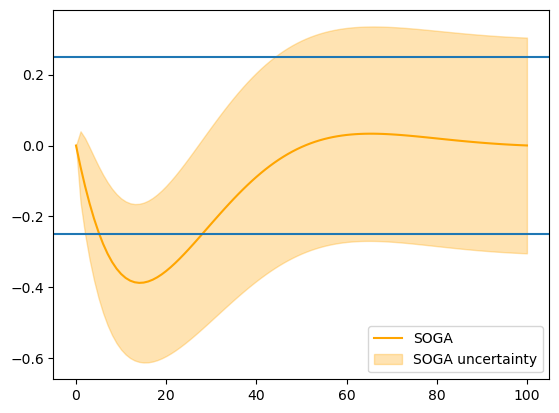

In [12]:
output_dist = start_SOGA(cfg, params_dict=params_dict)

y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

mean_y = output_dist.gm.mean().detach().numpy()[y_idx]
plt.plot(range(len(y_idx)), mean_y, color='orange', label='SOGA')
std_y = 2*torch.sqrt(torch.diag(output_dist.gm.cov()[y_idx, :][:, y_idx])).detach().numpy()
plt.fill_between(range(len(y_idx)), mean_y - std_y, mean_y + std_y, color='orange', alpha=0.3, label='SOGA uncertainty')


plt.axhline(y=0.25)
plt.axhline(y=-0.25)
plt.legend()

## Lotka-Volterra

Does not work, parameters are too unstable

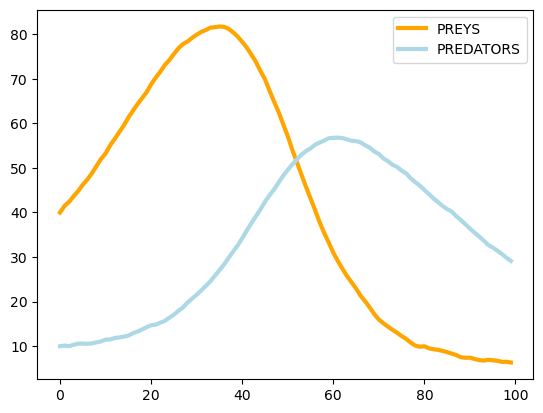

In [13]:
from cps.original_models import *

def original_model(T, x0, y0, a, b, c, d):

    x = torch.zeros(T)
    y = torch.zeros(T)
    x[0] = x0
    y[0] = y0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*a*x[i-1] - dt*b*x[i-1]*y[i-1] + distributions.Normal(0, 0.5).sample()
        y[i] = y[i-1] - dt*c*y[i-1] + dt*d*x[i-1]*y[i-1] + distributions.Normal(0, 0.5).sample()
    
    return x, y

x_list = []
y_list = []

init_params = {'T': 100, 'x0': 40., 'y0': 10., 'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.01}


for _ in range(10):

    x, y = original_model(**init_params)
    x_list.append(x)
    y_list.append(y)

x_list = torch.stack(x_list)
y_list = torch.stack(y_list)

plot_traj_set(x_list, single_traj=0, color='orange', label='PREYS')
plot_traj_set(y_list, single_traj=0, color='lightblue', label='PREDATORS')
plt.legend()

In [14]:
from optimization import *

soga_program = """
array[101] x;
array[101] y;

newx = 40.;
newy = 10.;

for i in range(101){

    x[i] = newx;
    y[i] = newy;
    
    term1x = _a*x[i];
    term2x = _b*x[i];
    term2x = term2x*y[i];

    term1y = _c*y[i];
    term2y = _d*x[i];
    term2y = term2y*y[i];

    newx = x[i] + 0.1*term1x - 0.1*term2x + gauss(0., 0.5);
    newy = y[i] - 0.1*term1y + 0.1*term2y + gauss(0., 0.5);

    } end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.01})

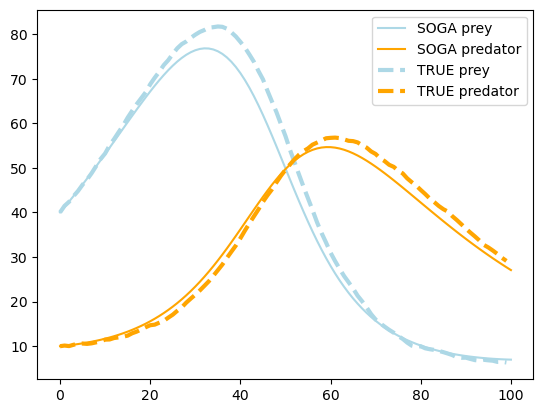

In [15]:
x_idx = [i for i in range(output_dist.gm.n_dim()) if 'x[' in output_dist.var_list[i]]
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

plt.plot(range(len(x_idx)), output_dist.gm.mean().detach().numpy()[x_idx], color='lightblue', label='SOGA prey')
plt.plot(range(len(y_idx)), output_dist.gm.mean().detach().numpy()[y_idx], color='orange', label='SOGA predator')

plot_traj_set(x_list, single_traj=0, ls='--', color='lightblue', label='TRUE prey')
plot_traj_set(y_list, single_traj=0, ls='--', color='orange', label='TRUE predator')
plt.legend()

In [16]:
# The loss maximize the probability of predators being < 40 starting from t=20

loss = lambda dist : 1-dist.gm.marg_cdf(torch.tensor([40.]*80), idx=list(range(121, 201))) 

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.005}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=1e-5)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")


a: 0.5000100135803223 b: 0.019989999011158943 c: 0.3000100255012512 d: 0.004989999812096357  loss: 0.9561198949813843
a: 0.5000199675559998 b: 0.01998000033199787 c: 0.3000200390815735 d: 0.004979999735951424  loss: 0.9564499258995056
a: 0.5000298619270325 b: 0.01997000351548195 c: 0.30003005266189575 d: 0.004969999194145203  loss: 0.9567763805389404
a: 0.5000396370887756 b: 0.019960008561611176 c: 0.30004003643989563 d: 0.004959998186677694  loss: 0.9570996761322021
a: 0.5000492334365845 b: 0.0199500173330307 c: 0.3000500202178955 d: 0.004949996713548899  loss: 0.9574192762374878
a: 0.5000585913658142 b: 0.019940029829740524 c: 0.3000600039958954 d: 0.0049399943090975285  loss: 0.9577350616455078
a: 0.5000675916671753 b: 0.019930046051740646 c: 0.30006998777389526 d: 0.004929990973323584  loss: 0.9580472111701965
a: 0.500076174736023 b: 0.019920067861676216 c: 0.30007997155189514 d: 0.004919986706227064  loss: 0.9583559632301331
a: 0.5000794529914856 b: 0.01991012878715992 c: 0.300089

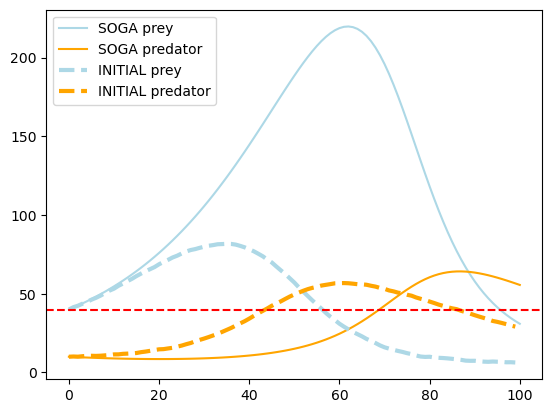

In [17]:
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

x_idx = [i for i in range(output_dist.gm.n_dim()) if 'x[' in output_dist.var_list[i]]
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

plt.plot(range(len(x_idx)), output_dist.gm.mean().detach().numpy()[x_idx], color='lightblue', label='SOGA prey')
plt.plot(range(len(y_idx)), output_dist.gm.mean().detach().numpy()[y_idx], color='orange', label='SOGA predator')

plot_traj_set(x_list, single_traj=0, ls='--', color='lightblue', label='INITIAL prey')
plot_traj_set(y_list, single_traj=0, ls='--', color='orange', label='INITIAL predator')
plt.axhline(y=40, color='red', linestyle='--')
plt.legend()